In [74]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim


In [75]:
learning_rate=0.005
batch_size = 10
epochs_count=150

In [76]:
phi = np.linspace(0, 20, 300)
r = 1 + phi

x = r * np.cos(phi)
y = r * np.sin(phi)
classes = np.zeros(300)
classes[:100] = 0
classes[100:200] = 1
classes[200:] = 2
points = np.column_stack((x + np.random.normal(scale=0.3,size = x.size), y + np.random.normal(scale=0.3,size=y.size)))

points

array([[ 9.27254153e-01, -3.06845728e-01],
       [ 8.06709343e-01,  4.56028512e-01],
       [ 1.07429854e+00,  2.20334725e-02],
       [ 1.81102574e+00, -6.77479176e-02],
       [ 1.90637307e+00,  3.47718280e-01],
       [ 1.46140945e+00,  1.55913688e-01],
       [ 1.82256634e+00,  5.97420252e-01],
       [ 1.00239280e+00,  8.53256643e-01],
       [ 1.11850565e+00,  1.21091788e+00],
       [ 1.78283694e+00,  5.73963574e-01],
       [ 1.09208689e+00,  1.15239977e+00],
       [ 1.19451066e+00,  1.22145284e+00],
       [ 1.09466247e+00,  1.17866057e+00],
       [ 1.14428286e+00,  1.54727268e+00],
       [ 1.01290763e+00,  1.26078142e+00],
       [ 1.10496291e+00,  1.84983994e+00],
       [ 5.68176102e-01,  1.67319918e+00],
       [ 1.06833912e+00,  2.22980417e+00],
       [ 9.40831683e-01,  2.02116953e+00],
       [ 5.02105716e-01,  1.45185096e+00],
       [ 6.26077864e-01,  2.22236412e+00],
       [ 6.22442976e-01,  2.33168680e+00],
       [ 1.35337503e-01,  2.44352818e+00],
       [ 2.

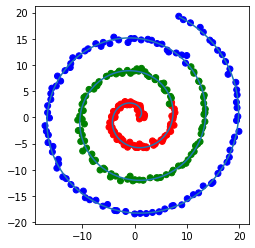

In [77]:
plt.plot(x,y)
plt.scatter(points[:,0], points[:,1], c=classes, cmap=matplotlib.colors.ListedColormap(['r','g','b']))
plt.gca().set_aspect('equal')
plt.show()

In [78]:
points_dev, points_test, classes_dev, classes_test = train_test_split(points, classes, test_size=0.1)

points_train, points_val, classes_train, classes_val = train_test_split(points_dev, classes_dev, test_size=0.2)



points_train= torch.from_numpy(points_train).type(torch.FloatTensor)
points_test = torch.from_numpy(points_test).type(torch.FloatTensor)
points_val = torch.from_numpy(points_val).type(torch.FloatTensor)


classes_train = torch.from_numpy(classes_train).type(torch.long)
classes_test = torch.from_numpy(classes_test).type(torch.long)
classes_val = torch.from_numpy(classes_val).type(torch.long)


ds_train = TensorDataset(points_train, classes_train)
ds_val = TensorDataset(points_val, classes_val)
ds_test = TensorDataset(points_test, classes_test)

dl_train = DataLoader(ds_train, batch_size=batch_size)
dl_val = DataLoader(ds_val, batch_size=batch_size)


val_size = (points_val.shape[0]/points.shape[0])
print(val_size)
train_size = (points_train.shape[0]/points.shape[0])
print(train_size)
test_size = (points_test.shape[0]/points.shape[0])
print(test_size)

0.18
0.72
0.1


In [79]:
class PointsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, 3)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval() 
    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

model = PointsNet()

optimizer = optim.Adam(model.parameters(), learning_rate)
def fit(model, criterion, epochs, optimizer, loader):
    for epoch in range(epochs):
        model.train()
        for i, (x, y) in enumerate(loader):
            optimizer.zero_grad()
            predictions = model(x)
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            
        acc_val = check_accuracy(dl_val, model)
        acc_train = check_accuracy(dl_train, model)
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch, loss, acc_train, acc_val))
        print()


In [80]:
fit(model, torch.nn.CrossEntropyLoss(), epochs_count, optimizer, dl_train)

x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max),
                     np.arange(y_min, y_max))

model.eval()

Epoch [0], train_loss: 0.5823, train_acc: 0.3287, val_acc: 0.2778

Epoch [1], train_loss: 0.7246, train_acc: 0.5324, val_acc: 0.4074

Epoch [2], train_loss: 0.7568, train_acc: 0.5694, val_acc: 0.5370

Epoch [3], train_loss: 0.8990, train_acc: 0.6759, val_acc: 0.6111

Epoch [4], train_loss: 0.9674, train_acc: 0.7454, val_acc: 0.6852

Epoch [5], train_loss: 0.6680, train_acc: 0.7593, val_acc: 0.7593

Epoch [6], train_loss: 0.4908, train_acc: 0.7593, val_acc: 0.7222

Epoch [7], train_loss: 0.8268, train_acc: 0.8009, val_acc: 0.7778

Epoch [8], train_loss: 0.3261, train_acc: 0.8796, val_acc: 0.8704

Epoch [9], train_loss: 0.8277, train_acc: 0.8380, val_acc: 0.8519

Epoch [10], train_loss: 0.3563, train_acc: 0.7731, val_acc: 0.7407

Epoch [11], train_loss: 0.8207, train_acc: 0.8657, val_acc: 0.8704

Epoch [12], train_loss: 0.5507, train_acc: 0.9028, val_acc: 0.9074

Epoch [13], train_loss: 0.2620, train_acc: 0.9398, val_acc: 0.8889

Epoch [14], train_loss: 0.3904, train_acc: 0.9583, val_acc

Epoch [125], train_loss: 0.0549, train_acc: 0.9907, val_acc: 1.0000

Epoch [126], train_loss: 0.2215, train_acc: 0.9815, val_acc: 1.0000

Epoch [127], train_loss: 0.2786, train_acc: 0.9907, val_acc: 1.0000

Epoch [128], train_loss: 0.0622, train_acc: 0.9907, val_acc: 1.0000

Epoch [129], train_loss: 0.1462, train_acc: 0.9907, val_acc: 1.0000

Epoch [130], train_loss: 0.0950, train_acc: 0.9907, val_acc: 1.0000

Epoch [131], train_loss: 0.3236, train_acc: 0.9907, val_acc: 1.0000

Epoch [132], train_loss: 0.3870, train_acc: 0.9907, val_acc: 1.0000

Epoch [133], train_loss: 0.2188, train_acc: 0.9861, val_acc: 1.0000

Epoch [134], train_loss: 0.0342, train_acc: 0.9907, val_acc: 1.0000

Epoch [135], train_loss: 0.3138, train_acc: 0.9954, val_acc: 1.0000

Epoch [136], train_loss: 0.0890, train_acc: 0.9861, val_acc: 1.0000

Epoch [137], train_loss: 0.6359, train_acc: 0.9954, val_acc: 1.0000

Epoch [138], train_loss: 0.2893, train_acc: 0.9907, val_acc: 1.0000

Epoch [139], train_loss: 0.0113, t

PointsNet(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

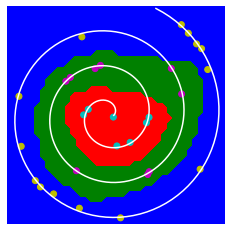

In [81]:
Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor))
_, preds = Z.max(1)

Z = preds.reshape(xx.shape)

plt.plot(x,y,c='w')
plt.scatter(points[:,0], points[:,1], c=classes, cmap=matplotlib.colors.ListedColormap(['r','g','b']))
plt.gca().set_aspect('equal')
plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(['r','g','b']))
plt.scatter(points_test[:,0], points_test[:,1], c=classes_test, cmap=matplotlib.colors.ListedColormap(['c','m','y']))
plt.axis('off')
plt.show()

In [ ]:
#желтые, циановые и фиолетовые точки - это точки тестовой выборки